In [3]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import emformer
import s3prl.hub

import torchaudio

C:\Users\tejas\AppData\Roaming\Python\Python38\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def mngu0_to_hprc(mng_arr):
    td = mng_arr[:, 0:2]
    tb = mng_arr[:, 2:4]
    tt = mng_arr[:, 4:6]
    li = mng_arr[:, 6:8]
    ul = mng_arr[:, 8:10]
    ll = mng_arr[:, 10:12]

    hprc_arr = np.zeros_like(mng_arr)
    hprc_arr[:, 0:2] = li
    hprc_arr[:, 2:4] = ul
    hprc_arr[:, 4:6] = ll
    hprc_arr[:, 6:8] = tt
    hprc_arr[:, 8:10] = tb
    hprc_arr[:, 10:12] = td


    for i in range(0, 12, 2):
        hprc_arr[:, i] = hprc_arr[:, i] * -1

    return hprc_arr

In [5]:
ema_gt = np.load("static/mngu0_s1_0008.npy")
ema_gt = mngu0_to_hprc(ema_gt)

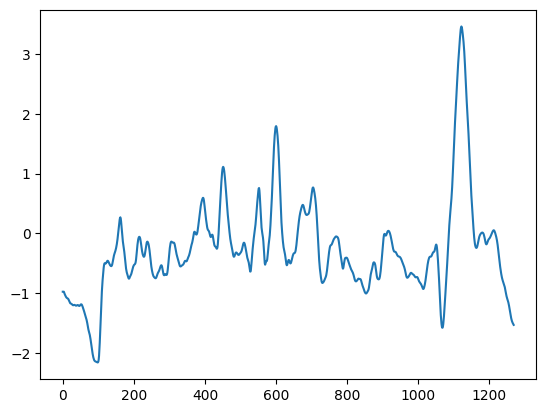

In [6]:
plt.plot(ema_gt[:, 0], label="x")

In [7]:
np.save("static/mngu0_s1_0008.npy", ema_gt)

In [11]:
def get_feature_model():
    print("--- Getting WavLM feature extractor ---")

    feature_model = getattr(s3prl.hub, "wavlm_large")()
    feature_model = feature_model.model.feature_extractor

    print("--- Loaded WavLM feature extractor ---")

    return feature_model

def get_emformer_model():
    print("--- Getting pretrained Emformer ---")

    input_dim=512
    num_heads=16
    ffn_dim=512
    num_layers=15
    segment_length=5
    left_context_length=20

    emformer_model = emformer.EMAEmformer(
        input_dim=input_dim,
        num_heads=num_heads,
        ffn_dim=ffn_dim,
        num_layers=num_layers,
        segment_length=segment_length,
        left_context_length=left_context_length
    )

    ckpt = torch.load(f"ckpts/emf_l{left_context_length}_r0_p{segment_length}_nh{num_heads}__nl{num_layers}_ffd{ffn_dim}_0.89.pth", map_location="cuda:0")

    emformer_model.load_state_dict(ckpt["emformer_state_dict"])

    print("--- Loaded pretrained Emformer ---")

    return emformer_model

In [12]:
feature_model = get_feature_model()

--- Getting WavLM feature extractor ---
--- Loaded WavLM feature extractor ---


In [13]:
emformer_model = get_emformer_model()

--- Getting pretrained Emformer ---
--- Loaded pretrained Emformer ---


In [16]:
audio, sr = torchaudio.load("static/mngu0_s1_0008.wav")
#audio = audio.squeeze(0)
feats = feature_model(audio)
print(feats.shape)
feats = feats.transpose(1, 2)

torch.Size([1, 512, 317])


In [17]:
ema_pred, state = emformer_model.predict_ema(feats, None)

In [18]:
ema_pred_hprc = mngu0_to_hprc(ema_pred)
np.save("static/mngu0_s1_0008_emf.npy", ema_pred_hprc)

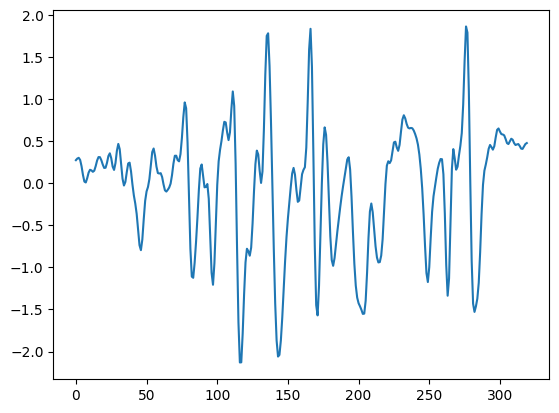

In [19]:
plt.plot(ema_pred[:, 7], label="y")

In [50]:
ema_pred, state = emformer_model.predict_ema(feats, None)